In [1]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
yolo = YOLO('model.pt')


In [3]:
image_path = 'tennis.jpg'
image = cv2.imread(image_path)

In [4]:
def detect_ball(model, image):
    results = model(image)
    center_ball = []
    bbox = []
    # Loop over the detections
    for result in results[0].boxes:
        # Get bounding box coordinates
        x1, y1, x2, y2 = result.xyxy[0].numpy().astype(int)

        bbox.append([[x1,y1],[x2,y2]])
        
        # Calculate the center of the bounding box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        center_ball.append([center_x, center_y])  # Save the center coordinates
        
        # Get class label and confidence
        class_id = int(result.cls[0])
        confidence = result.conf[0]
        
        # Draw bounding box and label on the image
        label = f"{model.names[class_id]} {confidence:.2f}"
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Draw the center of the bounding box
        cv2.circle(image, (center_x, center_y), 5, (0, 0, 255), -1)  # Red dot for the center
        return center_ball, bbox 
    

In [10]:
center_ball, bbox = detect_ball(yolo, image)


0: 320x256 1 Balls, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)


In [31]:
print(bbox)
print(bbox[0][1][1])

[[[296, 443], [402, 540]]]
540


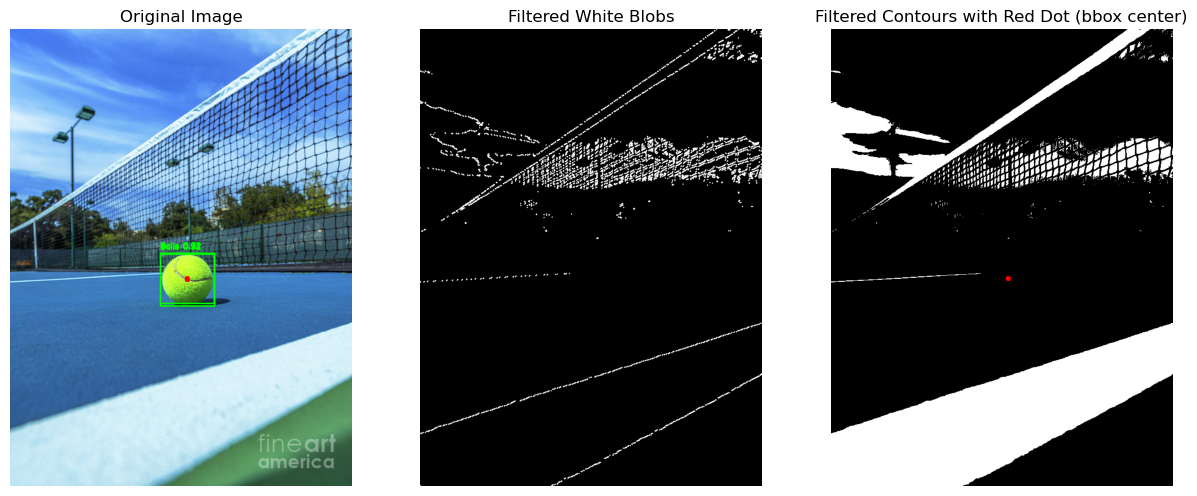

In [46]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold to isolate white regions
_, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

# Find contours of the white blobs
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize lists to hold valid contours and pixel locations
valid_contours = []
blob_pixel_locations = []

# Loop through each contour and filter based on bounding box
for contour in contours:
    is_valid_contour = False
    contour_points = []

    for point in contour[:, 0, :]:
        x, y = point[0], point[1]

        # Check if the point lies outside the bounding box
        if not (bbox[0][0][0] <= x <= bbox[0][1][0] and bbox[0][0][1] <= y <= bbox[0][1][1]):
            contour_points.append([x, y])
            is_valid_contour = True  # Mark the contour as valid

    if is_valid_contour:
        valid_contours.append(contour)  # Add contour to valid_contours list
        blob_pixel_locations.extend(contour_points)  # Add valid points to blob_pixel_locations

# Create an empty image to draw the filtered contours
filtered_img = np.zeros_like(image)  # Save as 'filtered_img'

# Draw the valid contours on the empty image
cv2.drawContours(filtered_img, valid_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Calculate the center of the bounding box
bbox_center_x = (bbox[0][0][0] + bbox[0][1][0]) // 2  # x center
bbox_center_y = (bbox[0][0][1] + bbox[0][1][1]) // 2  # y center

# Draw a red dot at the center of the bounding box
cv2.circle(filtered_img, (bbox_center_x, bbox_center_y), 5, (0, 0, 255), thickness=-1)  # Red dot (5px radius)

# Plot the original image, filtered white blobs, and valid contours
plt.figure(figsize=(15, 10))

# Original image subplot
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

# White blobs image subplot
plt.subplot(1, 3, 2)
white_blobs = np.zeros_like(image)
for blob in blob_pixel_locations:
    cv2.circle(white_blobs, (blob[0], blob[1]), 1, (255, 255, 255), thickness=-1)
plt.imshow(cv2.cvtColor(white_blobs, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Filtered White Blobs')

# Contours-only image subplot with red dot in bbox center
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB))  # Use 'filtered_img' here
plt.axis('off')
plt.title('Filtered Contours with Red Dot (bbox center)')

plt.show()


In [11]:
bbox 

[[[296, 443], [402, 540]]]

In [ ]:
# Show the image with detections and center points
cv2.imshow("YOLOv8 Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the output image
cv2.imwrite("output_image_with_centers.jpg", image)